In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', 105)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
sns.set()

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
#warnings.filterwarnings("ignore")

from subprocess import check_output

In [2]:
#モデル分割で使われる交差検証の数
nr_cv = 5

#SalePriceと特徴のlog値を使うためのスイッチ
use_logvals = 1

#相関で用いられるtarget
target = "SalePrice_Log"

#この閾値はpart3におけるML Regressorsで用いられる
min_val_corr = 0.4

#すでに使われるその他に似ていて、高い相関を見せる列を削除するスイッチ
drop_similar = 1

Some Useful Function

In [65]:
def get_best_score(grid):
    best_score = np.sqrt(-grid.best_score_)
    print(best_score)
    print(grid.best_params_)
    print(grid.best_estimator_)
    
    return best_score

def print_cols_large_corr(df, nr_c, targ):
    corr = df.corr()
    corr_abs = corr.abs()
    print (corr_abs.nlargest(nr_c, targ)[targ])
    
def plot_corr_matrix(df, nr_c, targ):
    corr = df.corr()
    corr_abs = corr.abs()
    cols = corr_abs.nlargest(nr_c, targ)[targ].index
    cm = np.corrcoef(df[cols].values.T)
    
    plt.figure(figsize=(nr_c/1.5, nr_c/1.5))
    sns.set(font_scale=1.25)
    sns.heatmap(cm, linewidth=1.5, annot=True, square=True,
               fmt=".2f", annot_kws={"size": 10},
               yticklabels=cols.values, xticklabels=cols.values
               )
    plt.show()

In [4]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [5]:
print(df_train.shape)
print("*"*50)
print(df_test.shape)

(1460, 81)
**************************************************
(1459, 80)


In [6]:
print(df_train.info())
print("*"*50)
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
df_train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [9]:
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [10]:
df_test.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1459.000000,1232.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,1458.000000,1458.000000,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1457.000000,1457.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.00000,1381.000000,1458.000000,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,2190.000000,57.378341,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,52.619342,554.294925,1046.117970,1156.534613,325.967786,3.543523,1486.045922,0.434454,0.065202,1.570939,0.377656,2.854010,1.042495,6.385195,0.58122,1977.721217,1.766118,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,421.321334,42.746880,22.376841,4955.517327,1.436812,1.113740,30.390071,21.130467,177.625900,455.268042,176.753926,437.260486,442.898624,398.165820,420.610226,44.043251,485.566099,0.530648,0.252468,0.555190,0.503017,0.829788,0.208472,1.508895,0.64742,26.431175,0.775945,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,1461.000000,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,407.000000,0.000000,0.000000,407.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.00000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,1825.500000,20.000000,58.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,0.000000,219.250000,784.000000,873.500000,0.000000,0.000000,1117.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.00000,1959.000000,1.000000,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,2190.000000,50.000000,67.000000,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,350.500000,0.000000,460.000000,988.000000,1079.000000,0.000000,0.000000,1432.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,0.00000,1979.000000,2.000000,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2554.500000,70.000000,80.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,164.000000,753.500000,0.000000,797.750000,1305.000000,1382.500000,676.000000,0.000000,1721.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.00000,2002.000000,2.000000,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2919.000000,190.000000,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,1526.000000,2140.000000,5095.000000,5095.000000,1862.000000,1064.000000,5095.000000,3.000000,2.000000,4.000000,2.000000,6.000000,2.000000,15.000000,4.00000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


Skewness: 1.882876
Kurtosis: 6.536282


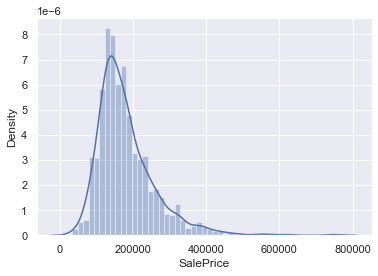

In [11]:
sns.distplot(df_train["SalePrice"])

print("Skewness: %f" % df_train["SalePrice"].skew())
print("Kurtosis: %f" % df_train["SalePrice"].kurt())

Skewness: 0.121335
Kurtosis: 0.809532


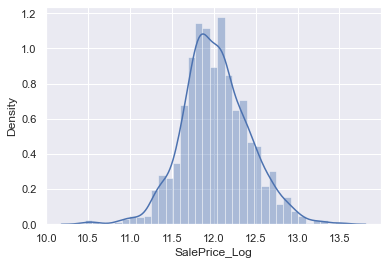

In [12]:
df_train["SalePrice_Log"] = np.log(df_train["SalePrice"])

sns.distplot(df_train["SalePrice_Log"])

print("Skewness: %f" % df_train["SalePrice_Log"].skew())
print("Kurtosis: %f" % df_train["SalePrice_Log"].kurt())

df_train.drop("SalePrice", axis=1, inplace=True)

Numerical and Categorical features

In [13]:
numerical_feats = df_train.dtypes[df_train.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = df_train.dtypes[df_train.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  38
Number of Categorical features:  43


In [14]:
print(df_train[numerical_feats].columns)
print("*" * 100)
print(df_train[categorical_feats].columns)

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice_Log'],
      dtype='object')
****************************************************************************************************
Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Founda

In [15]:
df_train[numerical_feats].head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice_Log
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,12.247694
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,12.109011
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,12.317167
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,11.849398
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,12.429216


In [16]:
df_train[categorical_feats].head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


List of features with missing values

In [17]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum() / df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=["Total", "Percent"])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [18]:
cols_fillna = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
               'GarageQual','GarageCond','GarageFinish','GarageType', 'Electrical',
               'KitchenQual', 'SaleType', 'Functional', 'Exterior2nd', 'Exterior1st',
               'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2',
               'MSZoning', 'Utilities']

for col in cols_fillna:
    df_train[col].fillna("None", inplace=True)
    df_test[col].fillna("None", inplace=True)

In [19]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum() / df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=["Total", "Percent"])
missing_data.head()

,Total,Percent
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
MasVnrArea,8,0.005479
SalePrice_Log,0,0.000000
ExterCond,0,0.000000


In [20]:
df_train.fillna(df_train.mean(), inplace=True)
df_test.fillna(df_test.mean(), inplace=True)

In [21]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum() / df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=["Total", "Percent"])
missing_data.head()

,Total,Percent
SalePrice_Log,0,0.0
Heating,0,0.0
RoofStyle,0,0.0
RoofMatl,0,0.0
Exterior1st,0,0.0


Missing values in train data ?

In [22]:
df_train.isnull().sum().sum()

0

Missing values in test data ?

In [23]:
df_test.isnull().sum().sum()

0

In [24]:
for col in numerical_feats:
    print("{:15}".format(col), 
         "Skewness : {:05.2f}".format(df_train[col].skew()),
         "   ", 
         "Kurtosis : {:6.2f}".format(df_train[col].kurt()))


Id              Skewness : 00.00     Kurtosis :  -1.20
MSSubClass      Skewness : 01.41     Kurtosis :   1.58
LotFrontage     Skewness : 02.38     Kurtosis :  21.85
LotArea         Skewness : 12.21     Kurtosis : 203.24
OverallQual     Skewness : 00.22     Kurtosis :   0.10
OverallCond     Skewness : 00.69     Kurtosis :   1.11
YearBuilt       Skewness : -0.61     Kurtosis :  -0.44
YearRemodAdd    Skewness : -0.50     Kurtosis :  -1.27
MasVnrArea      Skewness : 02.68     Kurtosis :  10.15
BsmtFinSF1      Skewness : 01.69     Kurtosis :  11.12
BsmtFinSF2      Skewness : 04.26     Kurtosis :  20.11
BsmtUnfSF       Skewness : 00.92     Kurtosis :   0.47
TotalBsmtSF     Skewness : 01.52     Kurtosis :  13.25
1stFlrSF        Skewness : 01.38     Kurtosis :   5.75
2ndFlrSF        Skewness : 00.81     Kurtosis :  -0.55
LowQualFinSF    Skewness : 09.01     Kurtosis :  83.23
GrLivArea       Skewness : 01.37     Kurtosis :   4.90
BsmtFullBath    Skewness : 00.60     Kurtosis :  -0.84
BsmtHalfBa

Skewness : 1.366560
Kurtosis : 4.895121


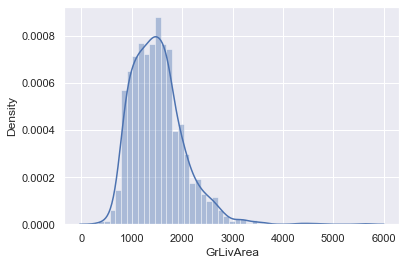

In [25]:
sns.distplot(df_train["GrLivArea"])

print("Skewness : %f" % df_train["GrLivArea"].skew())
print("Kurtosis : %f" % df_train["GrLivArea"].kurt())

Skewness : 12.207688
Kurtosis : 203.243271


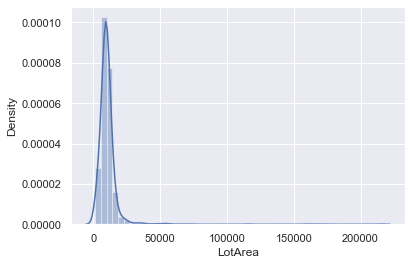

In [26]:
sns.distplot(df_train["LotArea"])

print("Skewness : %f" % df_train["LotArea"].skew())
print("Kurtosis : %f" % df_train["LotArea"].kurt())

In [27]:
for df in [df_train, df_test]:
    df["GrLivArea_Log"] = np.log(df["GrLivArea"])
    df.drop("GrLivArea", axis=1, inplace=True)
    df["LotArea_Log"] = np.log(df["LotArea"])
    df.drop("LotArea", axis=1, inplace=True)
    
numerical_feats = df_train.dtypes[df_train.dtypes != "object"].index

Skewness : -0.006995
Kurtosis : 0.282603


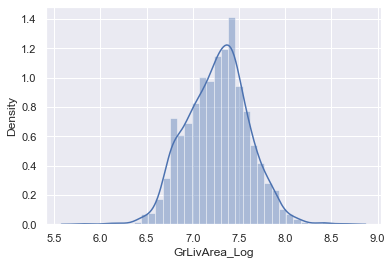

In [28]:
sns.distplot(df_train["GrLivArea_Log"])

print("Skewness : %f" % df_train["GrLivArea_Log"].skew())
print("Kurtosis : %f" % df_train["GrLivArea_Log"].kurt())

Skewness : -0.137994
Kurtosis : 4.713358


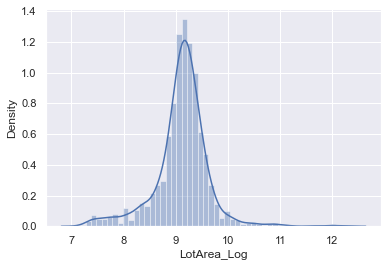

In [29]:
sns.distplot(df_train["LotArea_Log"])

print("Skewness : %f" % df_train["LotArea_Log"].skew())
print("Kurtosis : %f" % df_train["LotArea_Log"].kurt())

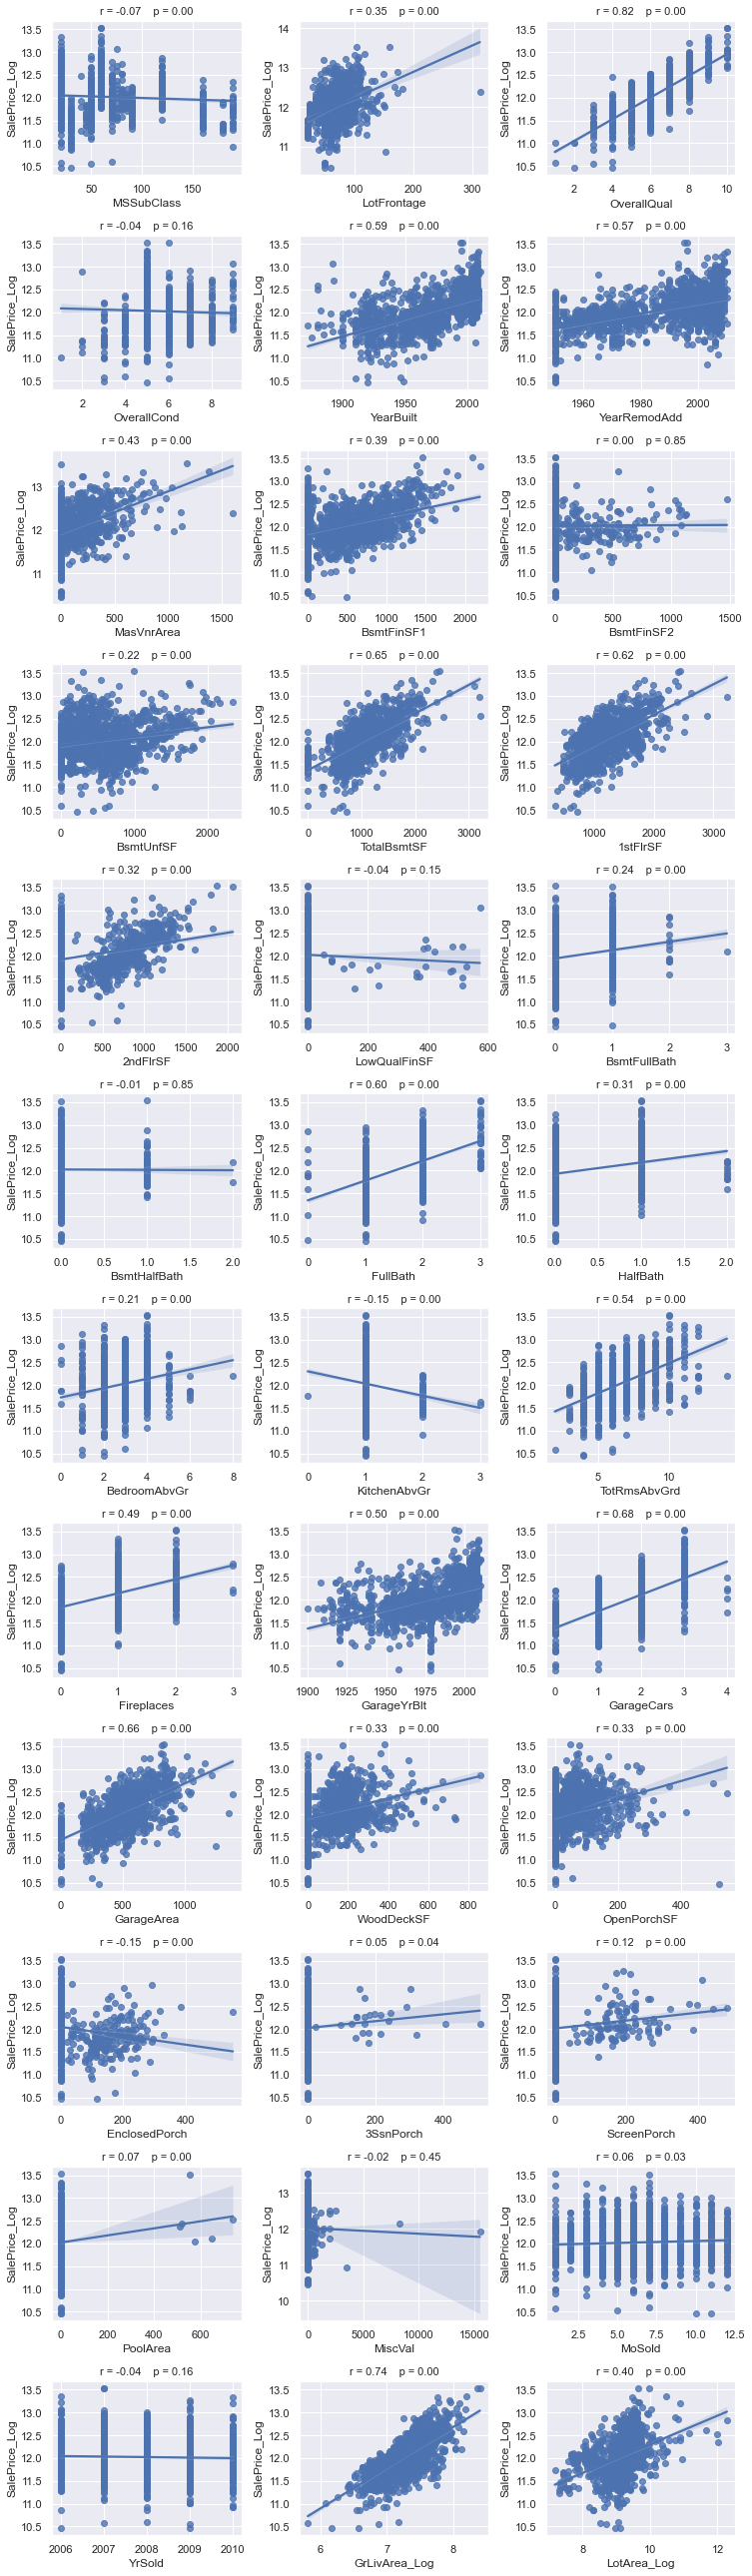

In [38]:
nr_rows = 12
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5, nr_rows*3))

li_num_feats = list(numerical_feats)
li_not_plot = ["Id", "SalePrice", "SalePrice_Log"]
li_plot_num_feats = [c for c in list(numerical_feats) if c not in li_not_plot]

for r in range(0, nr_rows):
    for c in range(0, nr_cols):
        i = r * nr_cols + c
        if i < len(li_plot_num_feats):
            sns.regplot(df_train[li_plot_num_feats[i]], df_train[target], ax=axs[r][c])
            stp = stats.pearsonr(df_train[li_plot_num_feats[i]], df_train[target])
            
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "    " + "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title, fontsize=11)

plt.tight_layout()
plt.show()

Outliers

In [32]:
df_train = df_train.drop(df_train[(df_train["OverallQual"] == 10) & (df_train["SalePrice_Log"] < 12.3)].index)

In [39]:
df_train = df_train.drop(df_train[(df_train["GrLivArea_Log"] > 8.3) & (df_train["SalePrice_Log"] < 12.5)].index)

In [42]:
corr = df_train.corr()
corr_abs = corr.abs()

nr_num_cols = len(numerical_feats)
ser_corr = corr_abs.nlargest(nr_num_cols, target)[target]

cols_abv_corr_limit = list(ser_corr[ser_corr.values > min_val_corr].index)
cols_bel_corr_limit = list(ser_corr[ser_corr.values <= min_val_corr].index)

In [53]:
print(ser_corr)
print("*" * 30)
print("List of numerical features with r above min_val_corr :")
print(cols_abv_corr_limit)
print("*" * 30)
print("List of numerical features with r below min_val_corr :")
print(cols_bel_corr_limit)

SalePrice_Log    1.000000
OverallQual      0.821404
GrLivArea_Log    0.737427
GarageCars       0.681033
GarageArea       0.656128
TotalBsmtSF      0.647563
1stFlrSF         0.620500
FullBath         0.595899
YearBuilt        0.587043
YearRemodAdd     0.565992
TotRmsAbvGrd     0.537702
GarageYrBlt      0.500842
Fireplaces       0.491998
MasVnrArea       0.433353
LotArea_Log      0.402814
BsmtFinSF1       0.392283
LotFrontage      0.352432
WoodDeckSF       0.334250
OpenPorchSF      0.325215
2ndFlrSF         0.319953
HalfBath         0.314186
BsmtFullBath     0.237099
BsmtUnfSF        0.221892
BedroomAbvGr     0.209036
EnclosedPorch    0.149029
KitchenAbvGr     0.147534
ScreenPorch      0.121245
PoolArea         0.074338
MSSubClass       0.073969
MoSold           0.057064
3SsnPorch        0.054914
LowQualFinSF     0.037951
YrSold           0.037151
OverallCond      0.036821
MiscVal          0.020012
Id               0.017774
BsmtHalfBath     0.005124
BsmtFinSF2       0.004863
Name: SalePr

List of categorical features and their unique values

In [54]:
for catg in list(categorical_feats):
    print(df_train[catg].value_counts())
    print("#" * 50)

RL         1149
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64
##################################################
Pave    1452
Grvl       6
Name: Street, dtype: int64
##################################################
None    1367
Grvl      50
Pave      41
Name: Alley, dtype: int64
##################################################
Reg    925
IR1    483
IR2     41
IR3      9
Name: LotShape, dtype: int64
##################################################
Lvl    1311
Bnk      61
HLS      50
Low      36
Name: LandContour, dtype: int64
##################################################
AllPub    1457
NoSeWa       1
Name: Utilities, dtype: int64
##################################################
Inside     1051
Corner      262
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64
##################################################
Gtl    1380
Mod      65
Sev      13
Name: LandSlope, dtype: int64
###########################

Relation to SalePrice for all categorical features

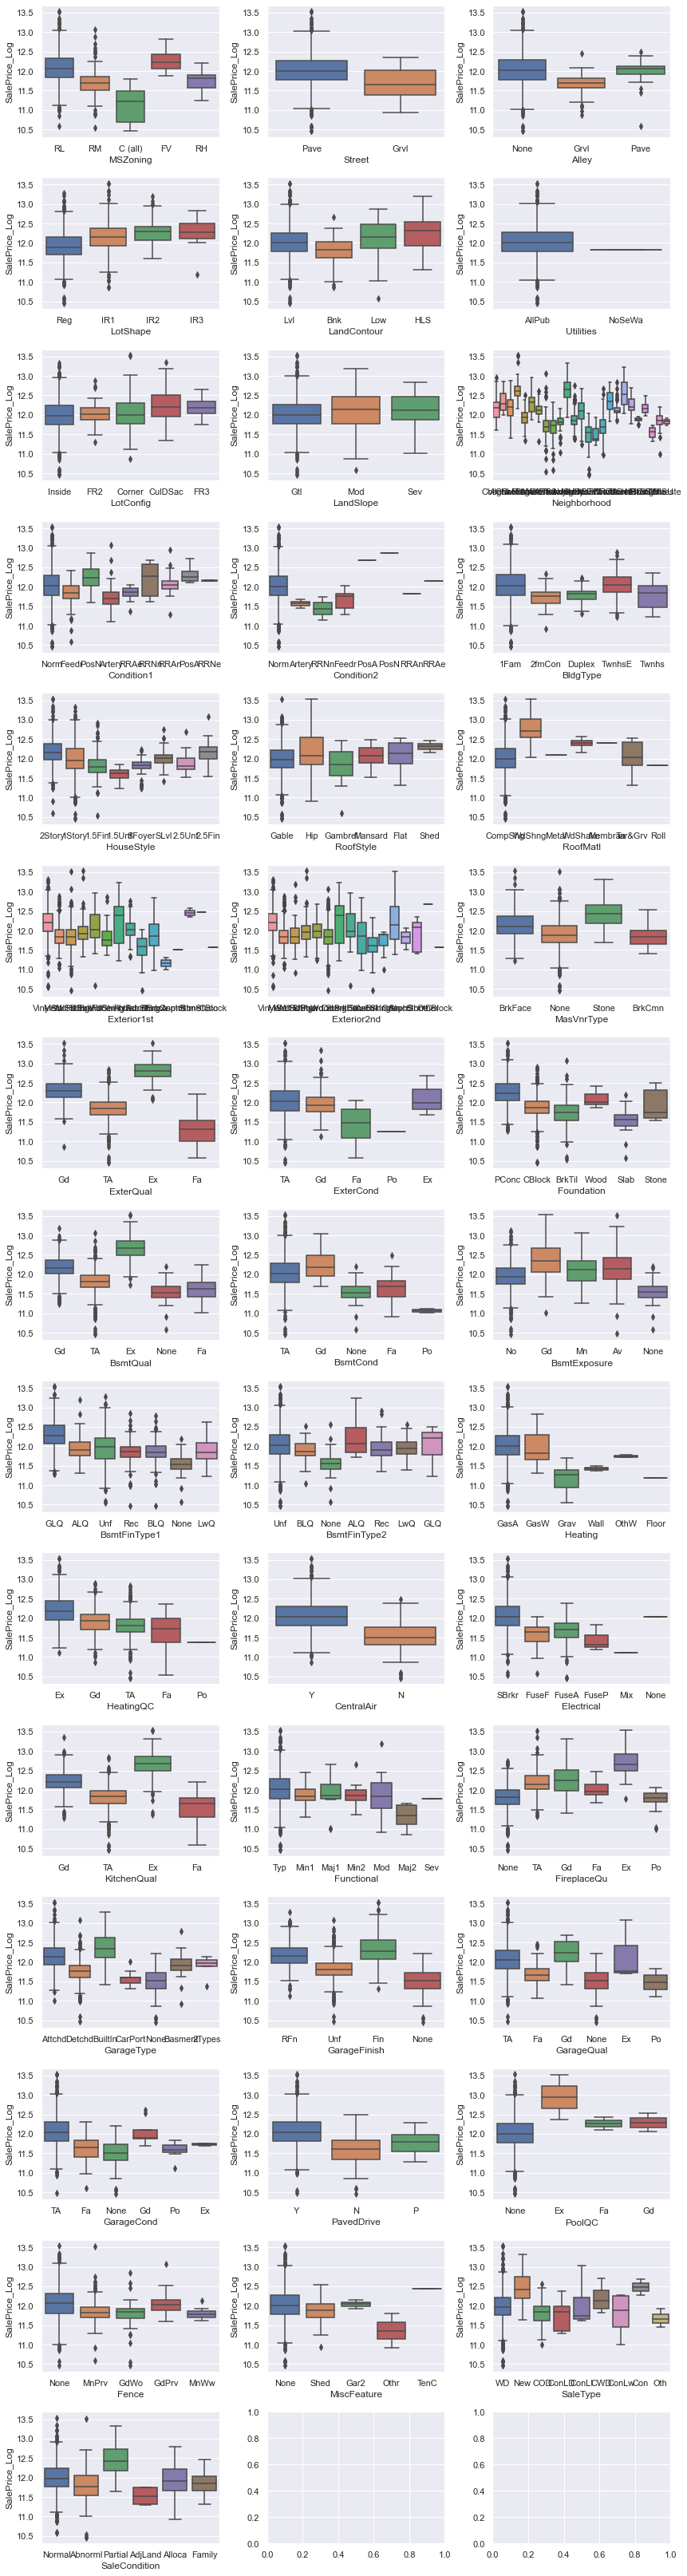

In [55]:
li_cat_feats = list(categorical_feats)
nr_rows = 15
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols * 4, nr_rows * 3))

for r in range(0, nr_rows):
    for c in range(0, nr_cols):
        i = r * nr_cols + c
        if i < len(li_cat_feats):
            sns.boxplot(x=li_cat_feats[i], y=target, data=df_train, ax=axs[r][c])
            
plt.tight_layout()
plt.show()

In [56]:
catg_strong_corr = ['MSZoning', 'Neighborhood', 'Condition2', 'MasVnrType', 'ExterQual', 
                     'BsmtQual','CentralAir', 'Electrical', 'KitchenQual', 'SaleType']

catg_weak_corr = ['Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 
                  'LandSlope', 'Condition1',  'BldgType', 'HouseStyle', 'RoofStyle', 
                  'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterCond', 'Foundation', 
                  'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 
                  'HeatingQC', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 
                  'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 
                  'SaleCondition' ]

Correlation matrix1

In [57]:
nr_feats = len(cols_abv_corr_limit)

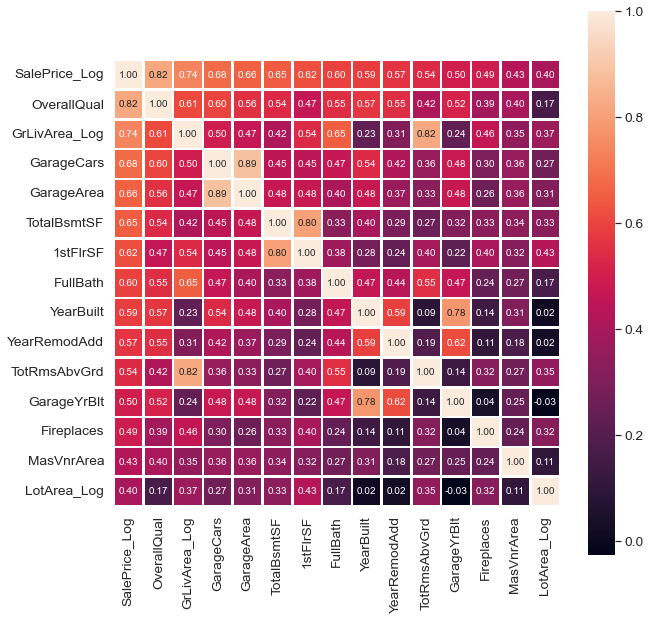

In [66]:
plot_corr_matrix(df_train, nr_feats, target)